In [1]:
import datacube
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')

In [2]:
%matplotlib inline

# Find and inspect one layer

In [3]:
ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to

datetime.datetime(2017, 4, 15, 19, 51, 53, 566905)

In [4]:
lon = 145.5895, 146.0649
lat = -17.53, -16.7007
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
x

<xarray.Dataset>
Dimensions:  (time: 1, x: 2413, y: 3861)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-15T19:51:53.566905
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
Data variables:
    vh       (time, y, x) float32 0.0275116 0.0315146 0.0429633 0.0525707 ...
    vv       (time, y, x) float32 0.395897 0.216501 0.150688 0.11122 ...
Attributes:
    crs:      epsg:3577

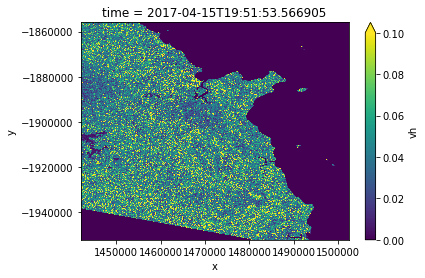

In [5]:
x.vh[:,::2,::2].plot(vmax=0.1)

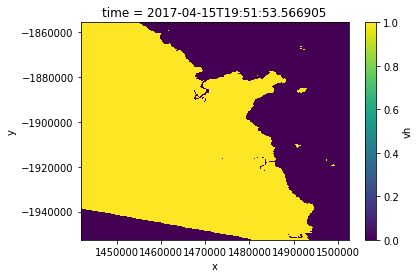

In [6]:
(x.vh != x.vh.nodata)[:,::10,::10].plot()

# Obtain all layers

Expected to take 5 to 10 minutes.

In [7]:
#z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))

In [8]:
import pickle
#with open('/g/data1/w85/sj9724/xarray.pickle', 'wb') as file:
#    pickle.dump(z, file, protocol=-1) # write xarray to disk

In [9]:
with open('/g/data1/w85/sj9724/xarray.pickle', 'rb') as file:
    z = pickle.load(file) # this only takes tens of seconds. (~6GB)

# Count observations
Patterns in the observation count often explain flaws in downstream products.

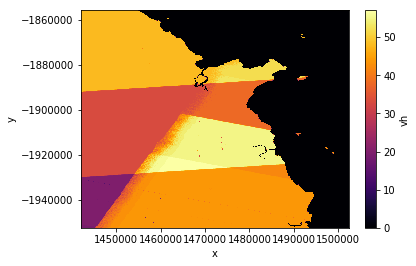

In [10]:
import numpy as np
counts = (z.vh!=z.vh.nodata).sum(dim='time')
counts[::4,::4].plot(cmap='inferno')

# Average signal
A naive mean will fail to account for different numbers of observations in different areas.

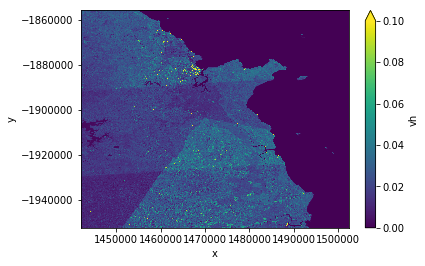

In [11]:
z.vh[:,::4,::4].mean(dim='time').plot(vmax=0.1)

In [12]:
x.vh.nodata

0

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


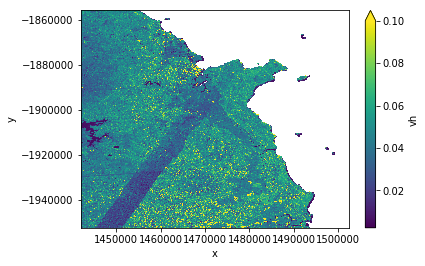

In [13]:
average = (z.vh[:,::4,::4].sum(dim='time') / counts)
average.plot(vmax=0.1)

# Problem image - Resolution
The above image has a strip of "problem" data. 
The following steps were taken to identify the problem -

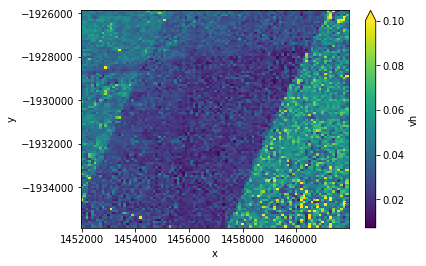

In [14]:
average[700:800,100:200].plot(vmax=0.1) # Zooming in on a section of the problem area

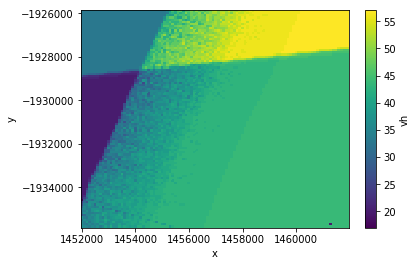

In [15]:
counts[::4,::4][700:800,100:200].plot() #Looking for all x all y every 4th step

Looking at the times where nodata - identify layers to zoom into

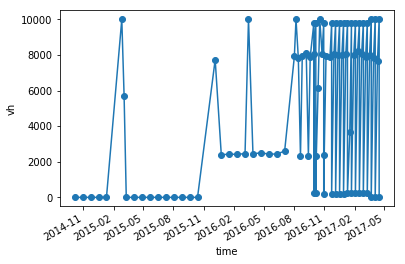

In [16]:
(z.vh!=z.vh.nodata)[:,::4,::4][:,700:800,100:200].sum(dim=['x','y']).plot(marker='o') 

Following 3 steps - analysis and comparison of images to identify 'problem' time steps - 
1a. Look at last 10 time layers - 5 columns then wrap to next 5 - identify images that show 'bleeding' between areas of data/nodata
1b.Displaying the 'bleeding' time images
2.

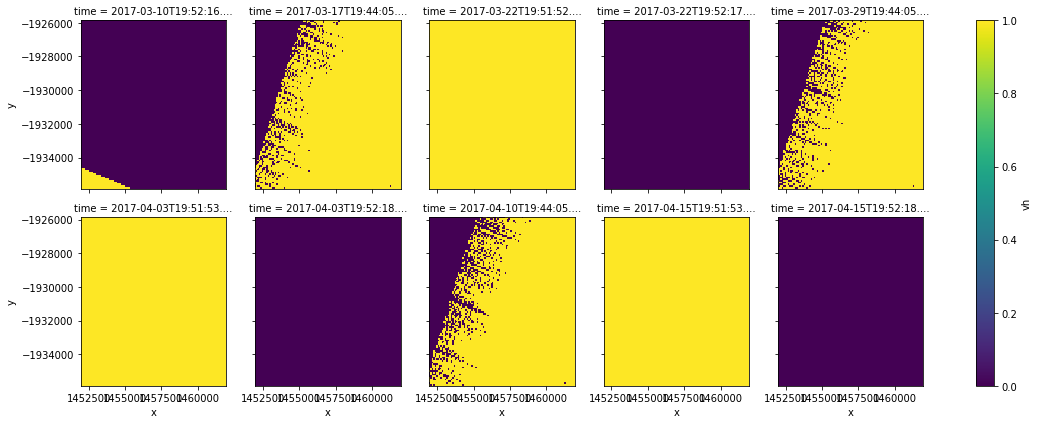

In [17]:
(z.vh!=z.vh.nodata)[:,::4,::4][-10:,700:800,100:200].plot(col='time', col_wrap=5) #1a.

In [18]:
(z.vh!=z.vh.nodata)[:,::4,::4][-10:,700:800,100:200].time #1b.show the time of the 'bleeding' images

<xarray.DataArray 'time' (time: 10)>
array(['2017-03-10T19:52:16.316473000', '2017-03-17T19:44:05.187420000',
       '2017-03-22T19:51:52.531304000', '2017-03-22T19:52:17.531710000',
       '2017-03-29T19:44:05.401794000', '2017-04-03T19:51:53.017654000',
       '2017-04-03T19:52:18.017566000', '2017-04-10T19:44:05.949922000',
       '2017-04-15T19:51:53.566905000', '2017-04-15T19:52:18.566845000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-03-10T19:52:16.316473 ...
Attributes:
    units:    seconds since 1970-01-01 00:00:00

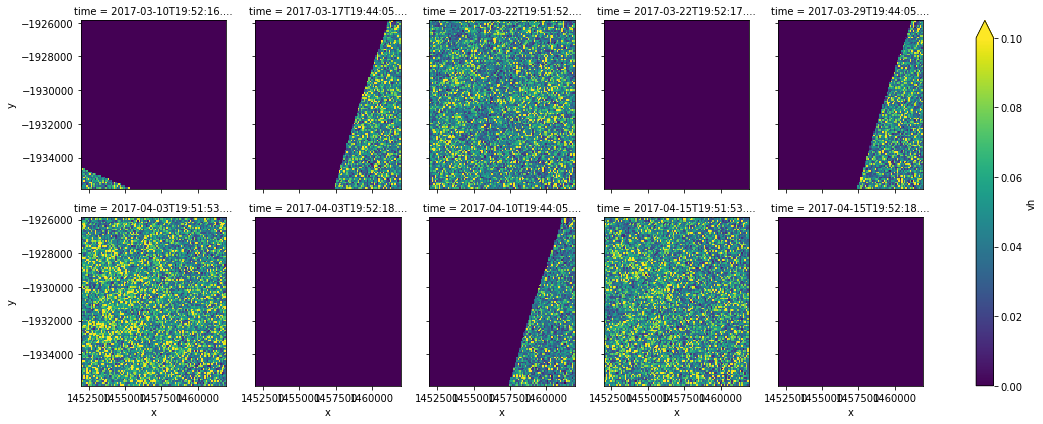

In [19]:
(z.vh)[:,::4,::4][-10:,700:800,100:200].plot(col='time', col_wrap=5, vmax=0.1)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


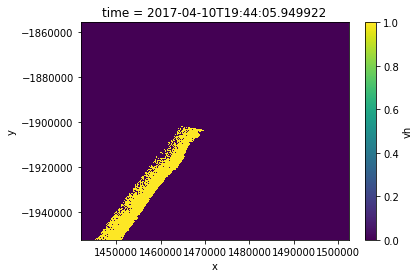

In [20]:
problem = z.sel(time='2017-04-10T19:44:05.949922000').vh[::4,::4].copy()
problem.data[problem.data==0] = np.nan
#problem.plot(vmax=0.00001)
(problem < 0.0001).plot() # problem identified - areas where the data is very close to zero but not quite

We now run the same script that produced the 'problem' image but define where there is data >0.001.  Voilà! Clean image

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


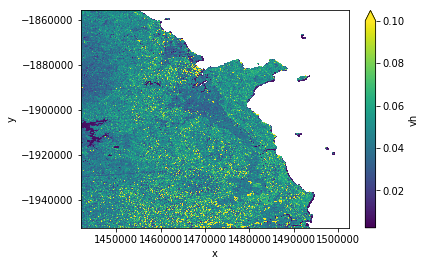

In [21]:
new_counts = (z.vh>0.001).sum(dim='time')
new_average = (z.vh[:,::4,::4].sum(dim='time') / new_counts)
new_average.plot(vmax=0.1)

In [22]:
with open('/g/data1/w85/sj9724/average_radar', 'wb') as file:
    pickle.dump(new_average, file, protocol=-1) # write xarray to disk